In [2]:
import numpy as np
from blimpy import read_header, Waterfall, Filterbank

%matplotlib inline
import matplotlib.pyplot as plt

import sys, os, glob
sys.path.append("../../setigen")
import setigen as stg

# tsamp = 1.0
# fch1 = 6095.214842353016
# df = -1.0e-06

tsamp = 18.253611008
fch1 = 6095.214842353016
df = -2.7939677238464355e-06

fchans = 1024
tchans = 32

fs = np.arange(fch1, fch1 + fchans*df, df)
ts = np.arange(0, tchans*tsamp, tsamp)

In [3]:
# basic cnn training
from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf

import matplotlib.pyplot as plt
from keras.preprocessing import image

# dimensions of our images.
img_width, img_height = 32, 1024

dir = 'scintillated_timescales_32_1024_v2-2'
VERSION = 'v2-2'

train_data_dir = '/datax/scratch/bbrzycki/data/%s/train/' % (dir)
validation_data_dir = '/datax/scratch/bbrzycki/data/%s/validation/' % (dir)
nb_train_samples = 10000*4
nb_validation_samples = 500*4
epochs = 100
batch_size = 64

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model_dir = '/datax/scratch/bbrzycki/models/%s/' % dir
filepath = model_dir + '%s_%s.h5' % ('scintillated_timescales_32_1024', VERSION)

model.load_weights(filepath)

Using TensorFlow backend.


In [3]:
fn = '/datax/scratch/bbrzycki/data/blc00_guppi_58331_12383_DIAG_SGR_B2_0014.gpuspec.0000.fil'

In [4]:
read_header(fn)

{b'rawdatafile': b'guppi_58331_12383_DIAG_SGR_B2_0014.0000.raw',
 b'source_name': b'DIAG_SGR_B2',
 b'machine_id': 20,
 b'telescope_id': 6,
 b'src_raj': <Angle 17.78900667 hourangle>,
 b'src_dej': <Angle -28.3854 deg>,
 b'az_start': 0.0,
 b'za_start': 0.0,
 b'data_type': 1,
 b'fch1': 3151.464842353016,
 b'foff': -2.7939677238464355e-06,
 b'nchans': 67108864,
 b'nbeams': 1,
 b'ibeam': 1,
 b'nbits': 32,
 b'tstart': 58331.14332175926,
 b'tsamp': 18.253611008,
 b'nifs': 1}

6376.454830169678 6376.453399658203
blimpy.file_wrapper WARNING  Given f_stop < f_start, assuming reversed values.


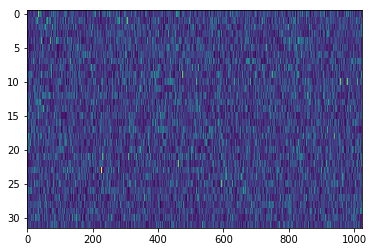

In [29]:
# Notable indices
# 198, 200
index = 7
fch1 = read_header(fn)[b'fch1']

f_start = fch1 + (index - 0) * fchans * df
f_stop = fch1 + (index + 1 - 0) * fchans * df

print(f_start, f_stop)
frame = stg.get_data(Waterfall(fn, f_start=f_start, f_stop=f_stop))[:32]
normalized = stg.normalize(frame, cols = 128, exclude = 0.2, use_median=False)
plt.imshow(normalized, aspect='auto')
plt.imsave('temp_observation.png', normalized)
# plt.colorbar()

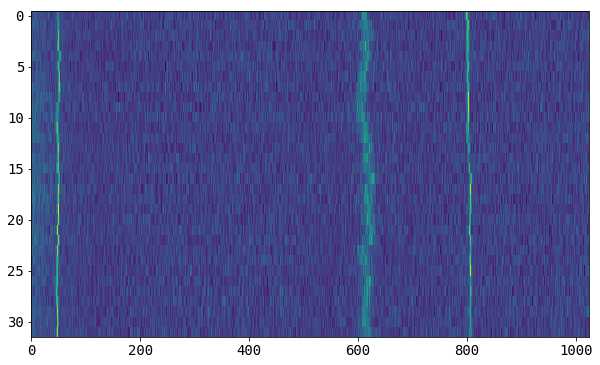

In [23]:
fig = plt.figure(figsize=(10,6))
plt.imshow(normalized[:,:], aspect='auto')


------
Choppy RFI: 0.00%
Constant: 3.40%
Noise: 94.81%
Scintillated: 1.78%


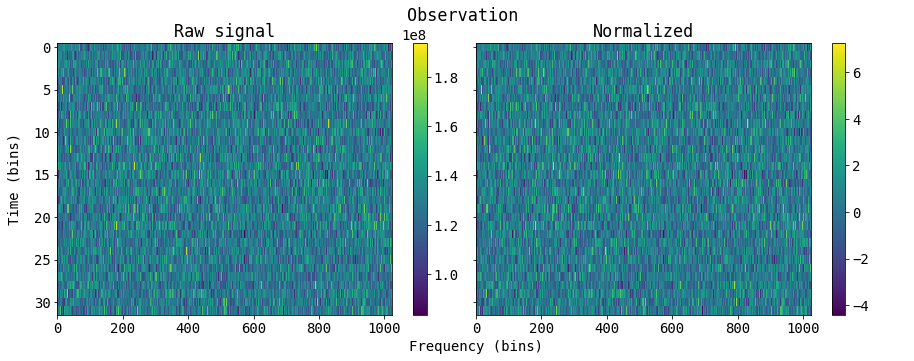

In [22]:
# start_index = np.random.randint(0,fchans)
# drift_rate = np.random.uniform(-start_index*df/(tsamp*tchans),
#                                (fchans-1-start_index)*df/(tsamp*tchans))
# line_width = np.random.uniform(0.02, 0.05) ** 3
# level = np.random.uniform(1,5)

# signal = stg.generate(ts,
#                       fs,
#                       stg.constant_path(f_start = fs[start_index], drift_rate = drift_rate),
#                       stg.constant_t_profile(level = 0),
#                       stg.gaussian_f_profile(width = line_width),
#                       stg.constant_bp_profile(level = 1.0))
# # fig = plt.figure(figsize=(10,6))
# # plt.imshow(signal, aspect='auto')
# # plt.colorbar()

# print('Drift Rate: %.02f Hz/s' % (drift_rate*1e6))
# print('Level: %.02f' % level)

# SET FONT
plt.rcParams.update({'font.family': 'monospace', 'font.size': 14})

# row and column sharing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharex='col', sharey='row')

img1a = ax1.imshow(frame, aspect='auto')
# plt.imsave('temp_no_noise.png', signal)
ax1.set_title('Raw signal')

# noisy = stg.normalize(stg.inject_noise(signal), cols = 128, exclude = 0.2, use_median=False)
img2a = ax2.imshow(normalized, aspect='auto')
plt.imsave('temp_normalized.png', normalized)
ax2.set_title('Normalized')

img2 = load_img('temp_normalized.png',False,target_size=(32,1024))
x = img_to_array(img2)
x = x / 255.
x = np.expand_dims(x, axis=0)
prob2 = model.predict_proba(x)[0]

# prob2 = (0.9567, 0.1083)
# prob3 = (0.9567, 0.1083, 0.0032)
# prob4 = (0.9567, 0.1083, 0.0032)

# if start_index < fchans / 2:
#     x_pos = 0.6
# else:
#     x_pos = 0.05

print('------')
print('Choppy RFI: %.02f%%' % (prob2[0] * 100))
print('Constant: %.02f%%' % (prob2[1] * 100))
print('Noise: %.02f%%' % (prob2[2] * 100))
print('Scintillated: %.02f%%' % (prob2[3] * 100))
    
# text = '{pulsed:<12} {value1:>7}\n{constant:<12} {value2:>7}'.format(pulsed='Present:',
#                                                                      value1='%.02f%%' % (prob2[1]*100),
#                                                                      constant='Not present:',
#                                                                      value2='%.02f%%' % (prob2[0]*100))    
# ax2.text(x_pos, 0.85, text, fontsize = 10, weight='bold', color='white', transform=ax2.transAxes,
#         bbox=dict(facecolor='none', edgecolor='white', linewidth=2, boxstyle='round,pad=0.5'))

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

fig.suptitle('Observation')
plt.xlabel('Frequency (bins)')
plt.ylabel('Time (bins)')

plt.colorbar(img1a, ax = ax1)
plt.colorbar(img2a, ax = ax2)
# plt.tight_layout()

fig.subplots_adjust(wspace = 0.0)


plt.show()

/home/bryanb/miniconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (10) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


------
Choppy RFI: 100.00%
Constant: 0.00%
Noise: 0.00%
Scintillated: 0.00%


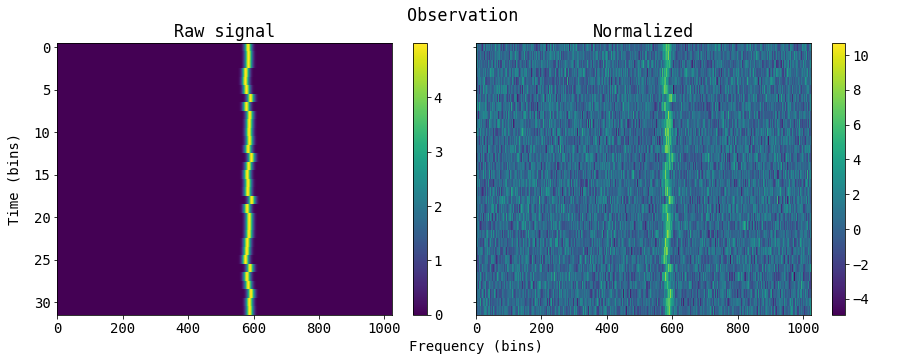

In [8]:
start_index = np.random.randint(0,fchans)
drift_rate = np.random.uniform(-start_index*df/(tsamp*tchans),
                               (fchans-1-start_index)*df/(tsamp*tchans))

line_width = np.random.uniform(0.02, 0.03) ** 3
# RFI is at practically 0 drift rate
drift_rate = 0
level = np.random.uniform(1,5)
level = 5
spread = np.random.uniform(0.0002, 0.0003)
# spread = line_width * 50.

frame = stg.generate(ts,
                      fs,
                      stg.choppy_rfi_path(f_start = fs[start_index], drift_rate = drift_rate, spread=spread, spread_type='gaussian'),
                      stg.constant_t_profile(level = level),
                      stg.gaussian_f_profile(width = line_width),
                      stg.constant_bp_profile(level = 1.0),
                      integrate = True)

normalized = stg.normalize(stg.inject_noise(frame), cols = 128, exclude = 0.2, use_median=False)

####

# SET FONT
plt.rcParams.update({'font.family': 'monospace', 'font.size': 14})

# row and column sharing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharex='col', sharey='row')

img1a = ax1.imshow(frame, aspect='auto')
# plt.imsave('temp_no_noise.png', signal)
ax1.set_title('Raw signal')

# noisy = stg.normalize(stg.inject_noise(signal), cols = 128, exclude = 0.2, use_median=False)
img2a = ax2.imshow(normalized, aspect='auto')
plt.imsave('temp_normalized.png', normalized)
ax2.set_title('Normalized')

img2 = load_img('temp_normalized.png',False,target_size=(32,1024))
x = img_to_array(img2)
x = x / 255.
x = np.expand_dims(x, axis=0)
prob2 = model.predict_proba(x)[0]

# prob2 = (0.9567, 0.1083)
# prob3 = (0.9567, 0.1083, 0.0032)
# prob4 = (0.9567, 0.1083, 0.0032)

# if start_index < fchans / 2:
#     x_pos = 0.6
# else:
#     x_pos = 0.05

print('------')
print('Choppy RFI: %.02f%%' % (prob2[0] * 100))
print('Constant: %.02f%%' % (prob2[1] * 100))
print('Noise: %.02f%%' % (prob2[2] * 100))
print('Scintillated: %.02f%%' % (prob2[3] * 100))
    
# text = '{pulsed:<12} {value1:>7}\n{constant:<12} {value2:>7}'.format(pulsed='Present:',
#                                                                      value1='%.02f%%' % (prob2[1]*100),
#                                                                      constant='Not present:',
#                                                                      value2='%.02f%%' % (prob2[0]*100))    
# ax2.text(x_pos, 0.85, text, fontsize = 10, weight='bold', color='white', transform=ax2.transAxes,
#         bbox=dict(facecolor='none', edgecolor='white', linewidth=2, boxstyle='round,pad=0.5'))

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

fig.suptitle('Observation')
plt.xlabel('Frequency (bins)')
plt.ylabel('Time (bins)')

plt.colorbar(img1a, ax = ax1)
plt.colorbar(img2a, ax = ax2)
# plt.tight_layout()

fig.subplots_adjust(wspace = 0.0)

plt.show()

------
Choppy RFI: 0.00%
Constant: 0.00%
Noise: 0.00%
Scintillated: 100.00%


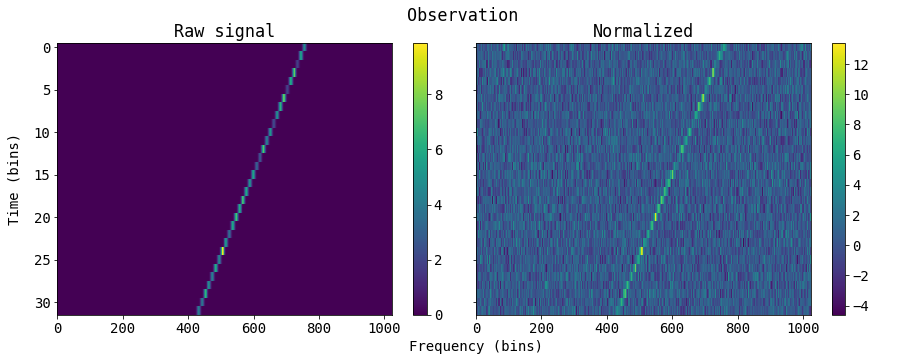

In [20]:
start_index = np.random.randint(0,fchans)
drift_rate = np.random.uniform(-start_index*df/(tsamp*tchans),
                               (fchans-1-start_index)*df/(tsamp*tchans))
line_width = np.random.uniform(0.02, 0.03) ** 3
#drift_rate = 0
level = np.random.uniform(1,5)
level = 5
period = np.random.uniform(1,5)
phase = np.random.uniform(0,period)
sigma = np.random.uniform(0.1, 2)
pulse_dir = 'rand'
width = np.random.uniform(0.1, 2)
pnum = 10
amplitude = np.random.uniform(level*2/3, level)

frame = stg.generate(ts,
                      fs,
                      stg.constant_path(f_start = fs[start_index], drift_rate = drift_rate),
                      stg.periodic_gaussian_t_profile(period, phase, sigma, pulse_dir, width, pnum, amplitude, level),
                      stg.gaussian_f_profile(width = line_width),
                      stg.constant_bp_profile(level = 1.0),
                      integrate = True)

normalized = stg.normalize(stg.inject_noise(frame), cols = 128, exclude = 0.2, use_median=False)

####

# SET FONT
plt.rcParams.update({'font.family': 'monospace', 'font.size': 14})

# row and column sharing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharex='col', sharey='row')

img1a = ax1.imshow(frame, aspect='auto')
# plt.imsave('temp_no_noise.png', signal)
ax1.set_title('Raw signal')

# noisy = stg.normalize(stg.inject_noise(signal), cols = 128, exclude = 0.2, use_median=False)
img2a = ax2.imshow(normalized, aspect='auto')
plt.imsave('temp_normalized.png', normalized)
ax2.set_title('Normalized')

img2 = load_img('temp_normalized.png',False,target_size=(32,1024))
x = img_to_array(img2)
x = x / 255.
x = np.expand_dims(x, axis=0)
prob2 = model.predict_proba(x)[0]

# prob2 = (0.9567, 0.1083)
# prob3 = (0.9567, 0.1083, 0.0032)
# prob4 = (0.9567, 0.1083, 0.0032)

# if start_index < fchans / 2:
#     x_pos = 0.6
# else:
#     x_pos = 0.05

print('------')
print('Choppy RFI: %.02f%%' % (prob2[0] * 100))
print('Constant: %.02f%%' % (prob2[1] * 100))
print('Noise: %.02f%%' % (prob2[2] * 100))
print('Scintillated: %.02f%%' % (prob2[3] * 100))
    
# text = '{pulsed:<12} {value1:>7}\n{constant:<12} {value2:>7}'.format(pulsed='Present:',
#                                                                      value1='%.02f%%' % (prob2[1]*100),
#                                                                      constant='Not present:',
#                                                                      value2='%.02f%%' % (prob2[0]*100))    
# ax2.text(x_pos, 0.85, text, fontsize = 10, weight='bold', color='white', transform=ax2.transAxes,
#         bbox=dict(facecolor='none', edgecolor='white', linewidth=2, boxstyle='round,pad=0.5'))

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

fig.suptitle('Observation')
plt.xlabel('Frequency (bins)')
plt.ylabel('Time (bins)')

plt.colorbar(img1a, ax = ax1)
plt.colorbar(img2a, ax = ax2)
# plt.tight_layout()

fig.subplots_adjust(wspace = 0.0)

plt.show()

------
Choppy RFI: 0.00%
Constant: 0.00%
Noise: 100.00%
Scintillated: 0.00%


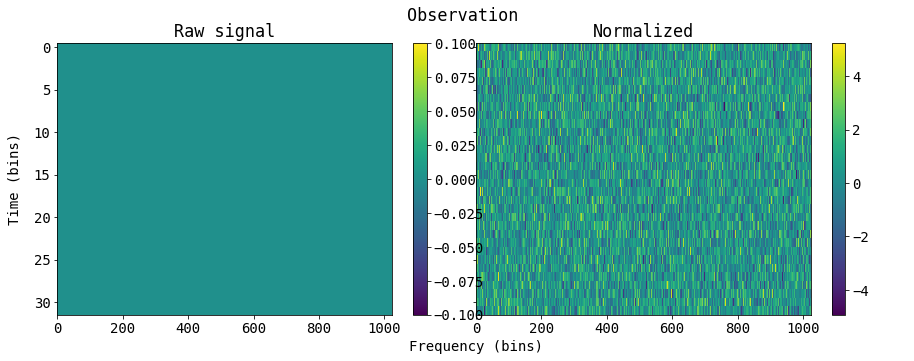

In [11]:
start_index = np.random.randint(0,fchans)
drift_rate = np.random.uniform(-start_index*df/(tsamp*tchans),
                               (fchans-1-start_index)*df/(tsamp*tchans))
frame = stg.generate(ts,
                      fs,
                      stg.constant_path(f_start = fs[start_index], drift_rate = drift_rate),
                      stg.constant_t_profile(level = 0),
                      stg.gaussian_f_profile(width = line_width),
                      stg.constant_bp_profile(level = 1.0),
                      integrate = False)

normalized = stg.normalize(stg.inject_noise(frame), cols = 128, exclude = 0.2, use_median=False)

####

# SET FONT
plt.rcParams.update({'font.family': 'monospace', 'font.size': 14})

# row and column sharing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharex='col', sharey='row')

img1a = ax1.imshow(frame, aspect='auto')
# plt.imsave('temp_no_noise.png', signal)
ax1.set_title('Raw signal')

# noisy = stg.normalize(stg.inject_noise(signal), cols = 128, exclude = 0.2, use_median=False)
img2a = ax2.imshow(normalized, aspect='auto')
plt.imsave('temp_normalized.png', normalized)
ax2.set_title('Normalized')

img2 = load_img('temp_normalized.png',False,target_size=(32,1024))
x = img_to_array(img2)
x = x / 255.
x = np.expand_dims(x, axis=0)
prob2 = model.predict_proba(x)[0]

# prob2 = (0.9567, 0.1083)
# prob3 = (0.9567, 0.1083, 0.0032)
# prob4 = (0.9567, 0.1083, 0.0032)

# if start_index < fchans / 2:
#     x_pos = 0.6
# else:
#     x_pos = 0.05

print('------')
print('Choppy RFI: %.02f%%' % (prob2[0] * 100))
print('Constant: %.02f%%' % (prob2[1] * 100))
print('Noise: %.02f%%' % (prob2[2] * 100))
print('Scintillated: %.02f%%' % (prob2[3] * 100))
    
# text = '{pulsed:<12} {value1:>7}\n{constant:<12} {value2:>7}'.format(pulsed='Present:',
#                                                                      value1='%.02f%%' % (prob2[1]*100),
#                                                                      constant='Not present:',
#                                                                      value2='%.02f%%' % (prob2[0]*100))    
# ax2.text(x_pos, 0.85, text, fontsize = 10, weight='bold', color='white', transform=ax2.transAxes,
#         bbox=dict(facecolor='none', edgecolor='white', linewidth=2, boxstyle='round,pad=0.5'))

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

fig.suptitle('Observation')
plt.xlabel('Frequency (bins)')
plt.ylabel('Time (bins)')

plt.colorbar(img1a, ax = ax1)
plt.colorbar(img2a, ax = ax2)
# plt.tight_layout()

fig.subplots_adjust(wspace = 0.0)

plt.show()

In [8]:
fn = '/datax/scratch/bbrzycki/data/blc00_guppi_58331_12383_DIAG_SGR_B2_0014.gpuspec.0000.fil'

fch1 = read_header(fn)[b'fch1']
nchans = read_header(fn)[b'nchans']

notable_indices = []

for index in range(0, int(nchans / fchans)):
    f_stop = fch1 + index * fchans * df
    f_start = fch1 + (index + 1) * fchans * df
    frame = stg.get_data(Waterfall(fn, f_start=f_start, f_stop=f_stop))
    normalized = stg.normalize(frame, cols = 128, exclude = 0.2, use_median=False)
    
    # Predict each frame
    plt.imsave('temp_normalized.png', normalized)

    img = load_img('temp_normalized.png',False,target_size=(32, 1024))
    x = img_to_array(img)
    x = x / 255.
    x = np.expand_dims(x, axis=0)
    prob = model.predict_proba(x)[0]
    
#     print(index)
    
    if prob[0] > 0.9:
#         pass
#         notable_indices.append(index)
        print('Found notable index: %s, rfi' % index)
    elif prob[1] > 0.9:
        pass
#         notable_indices.append(index)
#         print('Found notable index: %s, short' % index)
    elif prob[2] > 0.9:
        pass
#         notable_indices.append(index)
#         print('Found notable index: %s, medium' % index)
    elif prob[3] > 0.9:
#         pass
#         notable_indices.append(index)
        print('Found notable index: %s, scintillated' % index)
    else:
        pass
#         print('Index: %s, ???' % index)

Found notable index: 93, scintillated


KeyboardInterrupt: 

In [ ]:
# 259, 552, 557, 716, 717, 845, 848, 849, 884, 954, 955, 959. 962, 963, 993, 1015, 1016, 1017
# 1018, 1020, 1021, 1023, 1025, 1032, 1038, 1072, 1086, 1087, 1089, 1091, 1096, 1100, 1134, 
# 1137, 1138, 1139, 1140, 1141, 1142

In [19]:
fn = '/datax/scratch/bbrzycki/data/observations/blc15_guppi_58362_03640_DIAG_SGR_B2_0068.rawspec.0000.fil'

tsamp = 1.4316557653333333
fch1 = 3751.464843051508
df = -1.3969838619232178e-06

fch1 = read_header(fn)[b'fch1']
nchans = read_header(fn)[b'nchans']

notable_indices = []

index = 0
f_stop = fch1 + index * fchans * df
f_start = fch1 + (index + 1) * fchans * df
frame = stg.get_data(Waterfall(fn, f_start=f_start, f_stop=f_stop))
frame.shape

frame[:32].shape

(32, 1024)

In [ ]:
fn = '/datax/scratch/bbrzycki/data/observations/blc15_guppi_58362_03640_DIAG_SGR_B2_0068.rawspec.0000.fil'

tsamp = 1.4316557653333333
fch1 = 3751.464843051508
df = -1.3969838619232178e-06

fch1 = read_header(fn)[b'fch1']
nchans = read_header(fn)[b'nchans']

for index in range(0, int(nchans / fchans)):
    f_stop = fch1 + index * fchans * df
    f_start = fch1 + (index + 1) * fchans * df
    frame = stg.get_data(Waterfall(fn, f_start=f_start, f_stop=f_stop))
    normalized = stg.normalize(frame[:32], cols = 128, exclude = 0.2, use_median=False)
    
    # Predict each frame
    plt.imsave('temp_normalized.png', normalized)

    img = load_img('temp_normalized.png',False,target_size=(32, 1024))
    x = img_to_array(img)
    x = x / 255.
    x = np.expand_dims(x, axis=0)
    prob = model.predict_proba(x)[0]
    
#     print(index)
    
    if prob[0] > 0.9:
#         pass
#         notable_indices.append(index)
        print('Found notable index: %s, rfi' % index)
    elif prob[1] > 0.9:
#         pass
#         notable_indices.append(index)
        print('Found notable index: %s, short' % index)
    elif prob[2] > 0.9:
#         pass
#         notable_indices.append(index)
        print('Found notable index: %s, medium' % index)
    elif prob[3] > 0.9:
#         pass
#         notable_indices.append(index)
        print('Found notable index: %s, scintillated' % index)
    else:
        pass
#         print('Index: %s, ???' % index)

Found notable index: 0, scintillated
Found notable index: 1, scintillated
Found notable index: 2, scintillated
Found notable index: 3, scintillated
Found notable index: 4, scintillated
Found notable index: 5, scintillated
Found notable index: 6, scintillated
Found notable index: 7, scintillated
Found notable index: 8, scintillated
Found notable index: 9, scintillated
Found notable index: 10, scintillated
Found notable index: 11, scintillated
Found notable index: 12, scintillated
Found notable index: 13, scintillated
Found notable index: 14, scintillated
Found notable index: 15, scintillated
Found notable index: 16, scintillated
Found notable index: 17, scintillated
Found notable index: 18, scintillated
Found notable index: 19, scintillated
Found notable index: 20, scintillated
Found notable index: 21, scintillated
Found notable index: 22, scintillated
Found notable index: 23, scintillated
Found notable index: 24, scintillated
Found notable index: 25, scintillated
Found notable index: 2